# Visualization of MDP and SWG

复用 `train.py` 的日志与可视化逻辑，加载一个 KITTI-360 批次数据，并分别对同一批次应用 `weather_process` 与 `weather_process_swg`，将结果以与训练中 `global_step == 1` 时一致的方式记录到 TensorBoard。

In [43]:
import os
import sys
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import datasets as ds
import einops
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# 在 Notebook 中，__file__ 不可用；以当前工作目录推断 repo 根
repo_root = Path.cwd()
if (repo_root / "utils").exists() and (repo_root / "models").exists():
    pass
else:
    # 若当前不在仓库根目录，则向上寻找
    while not ((repo_root / "utils").exists() and (repo_root / "models").exists()):
        if repo_root.parent == repo_root:
            break
        repo_root = repo_root.parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import utils.option
from utils.lidar import LiDARUtility, get_hdl64e_linear_ray_angles
import utils.render

# 先导入模块并强制 reload，确保拿到最新实现
import importlib
import utils.weather as _wx
_wx = importlib.reload(_wx)
from utils.weather import weather_process, weather_process_swg

# 选择设备（不使用 Accelerator，直接在 Notebook 中输出）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Repo root set to: {repo_root}")
print(f"Using device: {device}")

Repo root set to: /home/24-nipeiyang/Codes/weathergen
Using device: cuda


In [44]:
# 定义最小化配置并选择投影与分辨率
cfg = utils.option.Config()

# 数据与分辨率配置（可按需调整）
cfg.data.dataset = "kitti_360"
cfg.data.projection = "spherical-1024"
cfg.data.resolution = (64, 1024)
cfg.data.depth_format = "log_depth"
cfg.data.min_depth = 0.0
cfg.data.max_depth = 100.0
cfg.data.train_depth = True
cfg.data.train_reflectance = True

# 训练与日志路径（仅用于本 Notebook 的日志写入）
cfg.training.output_dir = "logs/notebooks"
cfg.training.batch_size_train = 2
cfg.training.num_workers = 0
cfg.training.mixed_precision = "no"

print(cfg)

Config(data=DataConfig(dataset='kitti_360', depth_format='log_depth', projection='spherical-1024', train_depth=True, train_reflectance=True, resolution=(64, 1024), min_depth=0.0, max_depth=100.0), model=ModelConfig(architecture='efficient_unet', base_channels=64, temb_channels=None, channel_multiplier=(1, 2, 4, 8), num_residual_blocks=(3, 3, 3, 3), gn_num_groups=8, gn_eps=1e-06, attn_num_heads=8, coords_encoding='fourier_features', dropout=0.0, lfa=False), diffusion=DiffusionConfig(num_training_steps=None, num_sampling_steps=128, prediction_type='eps', loss_type='l2', noise_schedule='cosine', timestep_type='continuous'), training=TrainingConfig(train_model='train', batch_size_train=2, batch_size_eval=4, num_steps=300000, lr=0.0004, lr_warmup_steps=30000, pretrained_ckpt='logs/diffusion/kitti_360/spherical-1024/20250910T125905/models/diffusion_0000300000.pth', steps_save_image=5000, steps_save_model=50000, gradient_accumulation_steps=1, num_workers=0, adam_beta1=0.9, adam_beta2=0.99, ad

In [45]:
# 构建 LiDARUtility 与投影角度
if "spherical" in cfg.data.projection:
    coords = get_hdl64e_linear_ray_angles(*cfg.data.resolution)
elif "unfolding" in cfg.data.projection:
    coords = F.interpolate(
        torch.load(f"data/{cfg.data.dataset}/unfolding_angles.pth"),
        size=cfg.data.resolution,
        mode="nearest-exact",
    )
else:
    raise ValueError(f"Unknown projection: {cfg.data.projection}")

lidar_utils_cpu = LiDARUtility(
    resolution=cfg.data.resolution,
    depth_format=cfg.data.depth_format,
    min_depth=cfg.data.min_depth,
    max_depth=cfg.data.max_depth,
    ray_angles=coords,
)
lidar_utils = LiDARUtility(
    resolution=cfg.data.resolution,
    depth_format=cfg.data.depth_format,
    min_depth=cfg.data.min_depth,
    max_depth=cfg.data.max_depth,
    ray_angles=coords,
).to(device)

print("LiDARUtility ready.")

LiDARUtility ready.


In [46]:
# split_channels 与可视化辅助
channels = [1 if cfg.data.train_depth else 0, 1 if cfg.data.train_reflectance else 0]

def split_channels(image: torch.Tensor):
    depth, rflct = torch.split(image, channels, dim=1)
    return depth, rflct

def _to_hwc_numpy(img: torch.Tensor) -> np.ndarray:
    # 接受 (B,3,H,W) 或 (B,H,W,3) 或 (B,1,H,W)，返回首个样本的 HWC/灰度 numpy
    img = img[0] if img.ndim == 4 else img  # 可能是 CHW 或 HWC 或 1HW
    if img.ndim == 3 and img.shape[0] in (1, 3):
        # CHW -> HWC；1HW -> HW
        if img.shape[0] == 1:
            return img[0].cpu().numpy()
        else:
            return img.permute(1, 2, 0).cpu().numpy()
    elif img.ndim == 3 and img.shape[-1] in (1, 3):
        # HWC 或 HW1
        return img.cpu().numpy() if img.shape[-1] == 3 else img[..., 0].cpu().numpy()
    elif img.ndim == 2:
        return img.cpu().numpy()
    else:
        # 回退：尽力转换
        return img.detach().cpu().numpy()

@torch.inference_mode()
def show_images_inline(image, title_prefix: str = "name"):
    # 复用 train.py 中的处理
    image = lidar_utils.denormalize(image)
    depth, rflct = split_channels(image)

    # 计算可视化所需的派生量
    metric = lidar_utils.revert_depth(depth) if depth.numel() > 0 else None
    mask = (metric > lidar_utils.min_depth) & (metric < lidar_utils.max_depth) if depth.numel() > 0 else None
    xyz = lidar_utils.to_xyz(metric) / lidar_utils.max_depth * mask if depth.numel() > 0 else None
    normal = -utils.render.estimate_surface_normal(xyz) if depth.numel() > 0 else None
    if normal is not None:
        normal = lidar_utils.denormalize(normal)
    if depth.numel() > 0:
        R, t = utils.render.make_Rt(pitch=torch.pi / 4, yaw=torch.pi / 4, z=0.6)
        bev = utils.render.render_point_clouds(
            points=einops.rearrange(xyz, "B C H W -> B (H W) C"),
            colors=einops.rearrange(normal, "B C H W -> B (H W) C"),
            R=R.to(xyz),
            t=t.to(xyz),
        ).mul(255).clamp(0, 255).byte()
    else:
        bev = None

    # 将若干图像转换为可显示的 numpy
    vis = {}
    if depth.numel() > 0:
        vis["depth"] = _to_hwc_numpy(utils.render.colorize(depth))              # (B,3,H,W)->HWC
        vis["depth/orig"] = _to_hwc_numpy(utils.render.colorize(metric / lidar_utils.max_depth))
        vis["mask"] = _to_hwc_numpy(utils.render.colorize(mask, cm.binary_r))
        vis["bev"] = _to_hwc_numpy(bev) if bev is not None else None            # (B,H,W,3)->HWC
    if rflct.numel() > 0:
        vis["reflectance"] = _to_hwc_numpy(utils.render.colorize(rflct, cm.plasma))

    # 绘制
    keys = [k for k in ["depth", "depth/orig", "reflectance", "mask", "bev"] if k in vis and vis[k] is not None]
    cols = len(keys)
    plt.figure(figsize=(4 * cols, 4))
    for i, k in enumerate(keys):
        plt.subplot(1, cols, i + 1)
        plt.title(f"{title_prefix}/{k}")
        img = vis[k]
        cmap = None if (img.ndim == 3 and img.shape[-1] == 3) else "gray"
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
    plt.show()

print("inline show_images ready.")

inline show_images ready.


In [47]:
# 构建数据集与 DataLoader（collate_fn 仅做预处理，不在其中改天气）
dataset = ds.load_dataset(
    path=f"data/{cfg.data.dataset}",
    name=cfg.data.projection,
    split=ds.Split.TRAIN,
    # num_proc=cfg.training.num_workers,
    num_proc=64,
    trust_remote_code=True,
).with_format("torch")

print(dataset)

from torch.utils.data import DataLoader

# 取出 file_path 以供 raw SWG 使用
def _collate(samples):
    depth = torch.stack([s["depth"] for s in samples], dim=0)  # (B, 1, H, W)
    reflectance = None
    if cfg.data.train_reflectance:
        reflectance = torch.stack([s["reflectance"] for s in samples], dim=0)
    xyz = torch.stack([s["xyz"] for s in samples], dim=0)

    x_parts = []
    if cfg.data.train_depth:
        x_parts.append(lidar_utils_cpu.convert_depth(depth))
    if cfg.data.train_reflectance and reflectance is not None:
        x_parts.append(reflectance)
    x = torch.cat(x_parts, dim=1)
    x = lidar_utils_cpu.normalize(x)
    x = F.interpolate(x, size=cfg.data.resolution, mode="nearest-exact")

    # 记录上下文，后续两种方法复用同一个 weather_flag
    q = np.random.randint(0, 3)
    weather_flag = ["fog", "snow", "rain"][q]

    # 带出原始点云路径，若数据集缓存较旧可能不存在该字段
    file_paths = [s.get("file_path") if isinstance(s, dict) else None for s in samples]

    return {"x": x, "depth": depth, "xyz": xyz, "weather_flag": weather_flag, "file_paths": file_paths}

dataloader = DataLoader(
    dataset,
    batch_size=cfg.training.batch_size_train,
    shuffle=True,
    num_workers=64,
    collate_fn=_collate,
)

Dataset({
    features: ['sample_id', 'file_path', 'xyz', 'reflectance', 'depth', 'mask'],
    num_rows: 50348
})


In [48]:
# 取一个 batch，并分别应用 weather_process 与基于原始点云的 weather_process_swg_raw
batch = next(iter(dataloader))
x = batch["x"]
xyz = batch["xyz"]
depth = batch["depth"]
weather_flag = batch["weather_flag"]
file_paths = batch.get("file_paths", None)

print(f"Weather flag for this batch: {weather_flag}")

# 分别应用两种增强
x_wp = weather_process(x.clone(), weather_flag, xyz, depth)

# 使用 raw 版 SWG
x_swg = _wx.weather_process_swg_raw(
    src_bin_paths=file_paths,
    weather_flag=weather_flag,
    lidar_utils=lidar_utils_cpu,
    include_reflectance=bool(cfg.data.train_reflectance),
    resolution=cfg.data.resolution,
)

# 移动到设备
def _to_device(t):
    return t.to(device, non_blocking=True) if torch.is_tensor(t) else t

x_wp = _to_device(x_wp)
x_swg = _to_device(x_swg)

Weather flag for this batch: snow


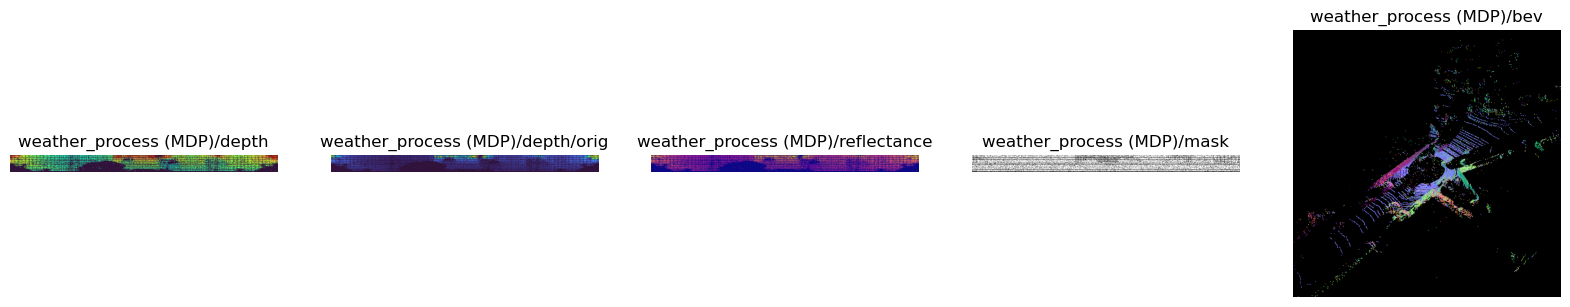

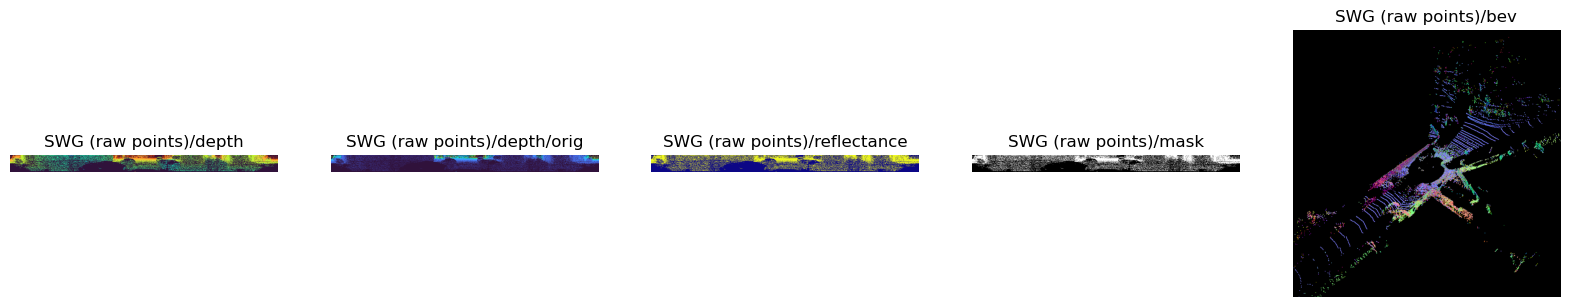

In [49]:
# 分别展示两种增强结果
show_images_inline(x_wp, title_prefix="weather_process (MDP)")
show_images_inline(x_swg, title_prefix="SWG (raw points)")